In [ ]:
import numpy as np
import os
import time
import copy
import seaborn as sns
import pandas as pd
import PIL
import PIL.Image
from PIL import Image, ImageOps
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from torchvision.io import read_image
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader

In [ ]:
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate, resize

In [ ]:
!pip install validators matplotlib
import json
import requests
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [ ]:
!kaggle datasets download "sartajbhuvaji/brain-tumor-classification-mri" --force

 88% 76.0M/86.8M [00:00<00:00, 130MB/s]
100% 86.8M/86.8M [00:00<00:00, 115MB/s]


In [ ]:
!unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

In [ ]:
#making training dataset

labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=150

In [ ]:
for label in labels:
    trainPath = os.path.join('Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join('Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 74/74 [00:00<00:00, 164.67it/s]


In [ ]:
X_train.shape

(2870, 150, 150, 3)

In [ ]:
X_test.shape

(394, 150, 150, 3)

Text(0.5, 1.0, 'Pituitary')

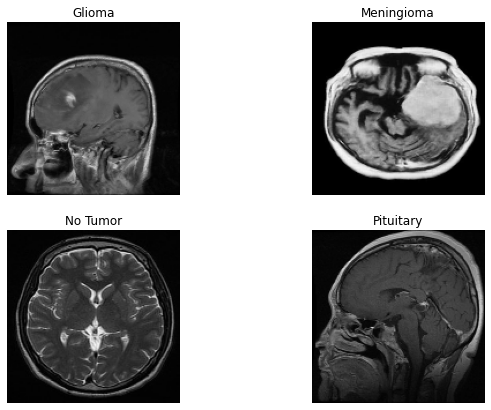

In [ ]:
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)

plt.imshow(X_train[9])
plt.axis('off')
plt.title("Glioma")

fig.add_subplot(rows, columns, 2)
plt.imshow(X_train[828])
plt.axis('off')
plt.title("Meningioma")

fig.add_subplot(rows, columns, 3)
plt.imshow(X_train[1650])
plt.axis('off')
plt.title("No Tumor")

fig.add_subplot(rows, columns, 4)
plt.imshow(X_train[2800])
plt.axis('off')
plt.title("Pituitary")

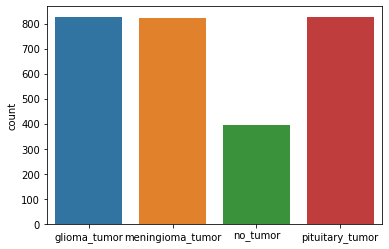

In [ ]:
sns.countplot(Y_train)

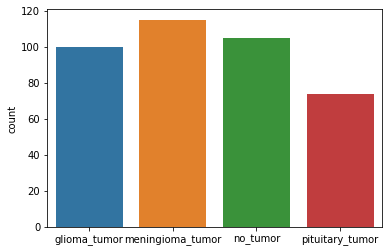

In [ ]:
sns.countplot(Y_test)

In [ ]:
from collections import Counter
Counter(Y_train)

Counter({'glioma_tumor': 826,
         'meningioma_tumor': 822,
         'no_tumor': 395,
         'pituitary_tumor': 827})

In [ ]:
# OneHotEncoding

y_train_new = []
for i in Y_train:
    y_train_new.append(labels.index(i))
Y_train = y_train_new
Y_train = tf.keras.utils.to_categorical(Y_train)


y_test_new = []
for i in Y_test:
    y_test_new.append(labels.index(i))
Y_test = y_test_new
Y_test = tf.keras.utils.to_categorical(Y_test)

In [ ]:
#Data Augmentation
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize((image_size,image_size)),
            # transforms.RandomRotation(degrees=(-25,20)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    
    return data_transformation


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):

        self.dataframe = df
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img = Image.open(img_name)
        img_normalized = self.transform(img)

        landmarks = self.dataframe.iloc[idx, 1]
        sample = {'data': img_normalized, 'label': int(landmarks)}

        return sample

In [ ]:
# Dataloader
train_path = ('Training/')
test_path = ('Testing/')

trainset = torchvision.datasets.ImageFolder(train_path, transform = images_transforms("training"))
testset = torchvision.datasets.ImageFolder(test_path, transform = images_transforms("test"))

testset,valset = torch.utils.data.random_split(testset, [150, 244])
train_loader=DataLoader(trainset,batch_size=32, shuffle=True,num_workers=2)

val_loader = DataLoader(valset, batch_size=32, shuffle=True,num_workers=2)

test_loader=DataLoader(testset,batch_size=32, shuffle=True,num_workers=2)

dataset_sizes = {"train":len(trainset), "val":len(valset), "test":len(testset)}
print(dataset_sizes)


{'train': 2870, 'val': 244, 'test': 150}


In [ ]:
trainset.classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
trainset.class_to_idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
test_loader

In [ ]:
val_loader

In [ ]:
trainfeature, trainlabel = next(iter(train_loader))
print(f"Feature Batch Shape: {trainfeature.size()}")
print(f"Label Batch Shape: {trainlabel.size()}")

Feature Batch Shape: torch.Size([32, 3, 150, 150])
Label Batch Shape: torch.Size([32])


In [ ]:
a,b=iter(test_loader).next()

In [ ]:
a.shape

torch.Size([32, 3, 150, 150])

In [ ]:
b

tensor([0, 2, 2, 3, 2, 1, 2, 0, 2, 2, 1, 1, 0, 1, 3, 2, 3, 2, 0, 1, 3, 0, 3, 0,
        2, 3, 3, 1, 3, 2, 2, 0])

In [ ]:
# MODELS

In [ ]:
# VGG19 trained over Imagenet
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
#VGG19

vgg19_model = models.vgg19(pretrained=True) # ImageNet
print(vgg19_model.classifier)
num_features=vgg19_model.classifier[6].in_features
features = list(vgg19_model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 4)])
vgg19_model.classifier = nn.Sequential(*features) 

if torch.cuda.is_available(): 
  vgg19_model.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
efficientNet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
print(efficientNet.classifier)
num_features=efficientNet.classifier[3].in_features
features = list(efficientNet.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 4)])
efficientNet.classifier = nn.Sequential(*features) 

if torch.cuda.is_available(): 
  efficientNet.cuda()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

Sequential(
  (pooling): AdaptiveAvgPool2d(output_size=1)
  (squeeze): Flatten()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=1280, out_features=1000, bias=True)
)


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = resnet.fc.in_features
resnet.fc=nn.Linear(num_ftrs,4)
# features = list(resnet.classifier.children())[:-1]
# features.extend([nn.Linear(num_features, 4)])
# resnet.classifier = nn.Sequential(*features)

if torch.cuda.is_available(): 
  resnet.cuda()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
trainAccuracy = []
trainLoss = []
testAccuracy = []
testLoss = []
def training_model(model, criterion, optimizer, scheduler, num_epochs=40):
    best_accuracy=0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
    
      #Evaluation and training on training dataset
      model.train()
      train_accuracy=0.0
      train_loss=0.0
      val_loss = 0.0
      
      for i, (images,labels) in enumerate(train_loader):
          if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
              
          optimizer.zero_grad()
          
          outputs=model(images)
          loss=criterion(outputs,labels)
          loss.backward()
          optimizer.step()
          
          
          train_loss+= loss.cpu().data*images.size(0)
          _,prediction=torch.max(outputs.data,1)
          
          train_accuracy+=int(torch.sum(prediction==labels.data))
          
      train_accuracy=train_accuracy/dataset_sizes['train']
      train_loss=train_loss/dataset_sizes['train']

      trainAccuracy.append(train_accuracy)
      trainLoss.append(train_loss)
  
      # Evaluation on testing dataset
      model.eval()
      
      test_accuracy=0.0
      for i, (images,labels) in enumerate(val_loader):
            if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
                
            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            loss = criterion(outputs, labels)
            # Loss and accuracy
            val_loss += loss.item()
            test_accuracy+=int(torch.sum(prediction==labels.data))
            y_actual.append(list(labels.data.cpu().numpy().flatten()))
            y_pred.append(list(prediction.detach().cpu().numpy().flatten()))
    
      test_accuracy=test_accuracy/dataset_sizes['val']
      val_loss = val_loss/dataset_sizes['val']
      print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Val Accuracy: '+str(test_accuracy) + ' Val Loss: ' + str(val_loss))
      testAccuracy.append(test_accuracy)
      testLoss.append(val_loss)
    
    if test_accuracy>best_accuracy:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_accuracy=test_accuracy
    best_accuracy = max(testAccuracy)
    print(f'Best val Acc: {best_accuracy:4f}')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
    


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(6):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {Y_test[preds[j]]}')
                plt.imshow(inputs.cpu().data[j].permute(1,2,0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
## Evaluate the performance of the latest model
val_loss = []
val_acc = []
def evaluate_model(final_model):
    y_val_actual=[]
    y_val_pred=[]
    val_accuracy=0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda()
            
        outputs=final_model(images)
        _,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))
        y_val_actual.extend(list(labels.data.cpu().numpy().flatten()))
        y_val_pred.extend(list(prediction.detach().cpu().numpy().flatten()))

        


    return y_val_actual,y_val_pred

In [ ]:
#ResNet50
y_pred = []
y_actual = []
criterion = nn.CrossEntropyLoss()
optimizer=optim.Adam(resnet.parameters(),lr=0.0002,weight_decay=0.0001) ## SGD, rmsprop lr=0.001
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
resnet_model = training_model(resnet, criterion, optimizer,exp_lr_scheduler,num_epochs=25)
## hyper parameter tuning: find the optimum hyper parameters: learning rate, optimizer, epochs, batch_size

In [ ]:
#VGG19
y_pred = []
y_actual = []
criterion = nn.CrossEntropyLoss()
optimizer=optim.Adam(vgg19_model.parameters(),lr=0.0002,weight_decay=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
vgg19_model = training_model(vgg19_model, criterion, optimizer,exp_lr_scheduler,num_epochs=25)


Epoch: 0 Train Loss: tensor(0.8807) Train Accuracy: 0.6094076655052265 Val Accuracy: 0.5245901639344263 Val Loss: 0.050560190296563945
Epoch: 1 Train Loss: tensor(0.4143) Train Accuracy: 0.8696864111498258 Val Accuracy: 0.6475409836065574 Val Loss: 0.049383351304492014
Epoch: 2 Train Loss: tensor(0.2521) Train Accuracy: 0.9139372822299652 Val Accuracy: 0.75 Val Loss: 0.04449315930976242
Epoch: 3 Train Loss: tensor(0.1745) Train Accuracy: 0.937630662020906 Val Accuracy: 0.680327868852459 Val Loss: 0.06860774731049772
Epoch: 4 Train Loss: tensor(0.1339) Train Accuracy: 0.9547038327526133 Val Accuracy: 0.6885245901639344 Val Loss: 0.05287509668068808
Epoch: 5 Train Loss: tensor(0.1701) Train Accuracy: 0.9477351916376306 Val Accuracy: 0.7008196721311475 Val Loss: 0.06724412812561285
Epoch: 6 Train Loss: tensor(0.1120) Train Accuracy: 0.9686411149825784 Val Accuracy: 0.7131147540983607 Val Loss: 0.08306008162068539
Epoch: 7 Train Loss: tensor(0.0935) Train Accuracy: 0.9700348432055749 Val A

In [ ]:
#EfficientNet
criterion = nn.CrossEntropyLoss()
optimizer=optim.Adam(efficientNet.parameters(),lr=0.0002,weight_decay=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
efficientNet = training_model(efficientNet, criterion, optimizer,exp_lr_scheduler,num_epochs=25)

Epoch: 0 Train Loss: tensor(0.5578) Train Accuracy: 0.8087108013937282 Val Accuracy: 0.680327868852459 Val Loss: 0.027162650080977895
Epoch: 1 Train Loss: tensor(0.1177) Train Accuracy: 0.9616724738675958 Val Accuracy: 0.7827868852459017 Val Loss: 0.02669625472827036
Epoch: 2 Train Loss: tensor(0.0425) Train Accuracy: 0.9895470383275261 Val Accuracy: 0.7008196721311475 Val Loss: 0.03307149498189082
Epoch: 3 Train Loss: tensor(0.0418) Train Accuracy: 0.9860627177700348 Val Accuracy: 0.7540983606557377 Val Loss: 0.03238323208738546
Epoch: 4 Train Loss: tensor(0.0217) Train Accuracy: 0.9947735191637631 Val Accuracy: 0.7745901639344263 Val Loss: 0.03316521424739087
Epoch: 5 Train Loss: tensor(0.0128) Train Accuracy: 0.9968641114982578 Val Accuracy: 0.7950819672131147 Val Loss: 0.03625799239170356
Epoch: 6 Train Loss: tensor(0.0096) Train Accuracy: 0.9979094076655052 Val Accuracy: 0.7909836065573771 Val Loss: 0.03861549032516167
Epoch: 7 Train Loss: tensor(0.0059) Train Accuracy: 0.99825783

In [ ]:
## Overfitting: when the model learns the train set well but is not able to generalize to other datasets (test set, val set, or new data that comes in the future)
## - Increase the train set
## - Data augmentation
## - Include regularizer (Dropout)

In [ ]:
y_val_actual,y_val_pred=evaluate_model(vgg19_model) #offical evaluation of model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm_arr = confusion_matrix(y_val_actual,y_val_pred)
cr = classification_report(y_val_actual,y_val_pred, target_names =  ['glioma','meningioma','no tumor','pituitary'])
print(cr)

              precision    recall  f1-score   support

      glioma       1.00      0.25      0.40        40
  meningioma       0.67      1.00      0.80        47
    no tumor       0.73      1.00      0.85        41
   pituitary       1.00      0.64      0.78        22

    accuracy                           0.75       150
   macro avg       0.85      0.72      0.71       150
weighted avg       0.82      0.75      0.70       150



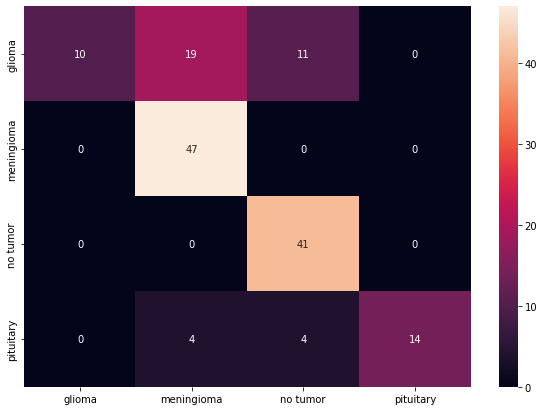

In [ ]:
df_cm = pd.DataFrame(cm_arr, index = [i for i in ['glioma','meningioma','no tumor','pituitary']], columns = [i for i in ['glioma','meningioma','no tumor','pituitary']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

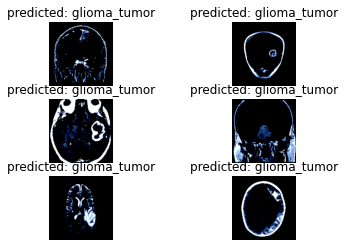

In [ ]:
visualize_model(resnet_model, num_images=6)

[0.2440820336341858, 0.08382535725831985, 0.21013447642326355, 0.09333260357379913, 0.06504389643669128, 0.0752895325422287, 0.09356484562158585, 0.042325712740421295, 0.02675803378224373, 0.07562994211912155, 0.1519785076379776, 0.07644497603178024, 0.056802112609148026, 0.02723637968301773, 0.012683621607720852, 0.09483038634061813, 0.024097803980112076, 0.04670604690909386, 0.027022825554013252, 0.06347943097352982, 0.037713419646024704, 0.029374465346336365, 0.04685908555984497, 0.030112693086266518, 0.028197968378663063, 0.557774007320404, 0.11770808696746826, 0.042480528354644775, 0.04184776172041893, 0.021650107577443123, 0.012837660498917103, 0.009646128863096237, 0.005892654415220022, 0.016626449301838875, 0.019695738330483437, 0.03049994632601738, 0.012132959440350533, 0.00870335940271616, 0.008829071186482906, 0.014444560743868351, 0.008265051059424877, 0.009668299928307533, 0.009625726379454136, 0.008020501583814621, 0.003960495349019766, 0.0037132934667170048, 0.0105836680

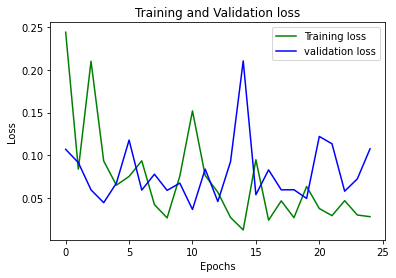

In [ ]:
from torch import IntTensor
# trainLoss = [IntTensor.item(i) for i in trainLoss]
print(trainLoss)
epochs = range(0,25)
plt.plot(epochs, trainLoss[:25], 'g', label='Training loss')
plt.plot(epochs, testLoss[:25], 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()